In [4]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle
import ROI_actions
from ROI_actions import *
# Getting my modules
sys.path.append('/home/jonathak/VisualEncoder/Analysis/Brain_maps')
from NIPS_utils import get_hemisphere_indices, get_roi_indices, get_roi_indices_per_hemisphere


# Setting up GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Appending Roman's path
sys.path.append('/home/romanb/PycharmProjects/BrainVisualReconst/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Loading the model
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
model = torch.load('/home/jonathak/VisualEncoder/Voxels_Prediction/model_ch128.pth').eval().cuda()

# Testing voxel embeddings
voxel_embeddings = model.voxel_embed # Has shape [315997, 256]

# Getting subject 1 indices

subject = 1

lh_start, lh_end = get_hemisphere_indices(subject, 'lh')
rh_start, rh_end = get_hemisphere_indices(subject, 'rh')    
sub_indices = np.arange(lh_start, rh_end)

voxel_embeddings = voxel_embeddings[sub_indices]


Using cache found in /home/matanyaw/.cache/torch/hub/facebookresearch_dinov2_main


In [6]:
# def compare_roi_dicts(roi_dict1, roi_dict2):
#     # This functoin is to see that the automation works correctly
#     if len(roi_dict1) != len(roi_dict2):
#         print("ROI dictionaries have different lengths.")
#         print(f'ROI dict 1 keys: {list(roi_dict1.keys())}')
#         print(f'ROI dict 2 keys: {list(roi_dict2.keys())}')

#     # check all ROIs in dict1 are in dict2
#     roi1_names = set(roi_dict1.keys())
#     roi2_names = set(roi_dict2.keys())
#     if roi1_names.symmetric_difference(roi2_names):
#         print("Some ROIs in dict1 are not in dict2 or vice versa.")
#         print(f'ROIs in dict1 but not in dict2: {roi1_names - roi2_names}')
#         print(f'ROIs in dict2 but not in dict1: {roi2_names - roi1_names}')
#         return False
#     for roi_name in roi1_names:
#         print('ROI name:', roi_name)
#         indices1 = roi_dict1[roi_name]
#         indices2 = roi_dict2[roi_name]
        
#         indices1_set = set(indices1)
#         indices2_set = set(indices2)
#         if indices1_set != indices2_set:
#             print(f"Indices for ROI '{roi_name}' differ between dictionaries.")
#             print(f"Indices in dict1: {indices1_set}")
#             print(f"Indices in dict2: {indices2_set}")
#             return False
#     return True

In [7]:
subject = 1

# Getting ROI indices

ROIs_bodies = ['EBA', 'FBA-1', 'FBA-2', 'mTL-bodies']
ROIs_faces = ['OFA', 'FFA-1', 'FFA-2', 'mTL-faces', 'aTL-faces']
ROIs_places = ['OPA', 'PPA', 'RSC']
ROIs_words = ['OWFA', 'VWFA-1', 'VWFA-2', 'mfs-words', 'mTL-words']
ROIs_visual = ['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']

ROI_names = ROIs_bodies + ROIs_faces + ROIs_places + ROIs_words + ROIs_visual

predefined_ROI_indices = {}

# Creating a dictionary of ROI indices (iterating over copy because we remove ROIs that don't exist)
for ROI in ROI_names.copy():
    
    roi_indices = get_roi_indices(subject, ROI)
    
    if roi_indices is None:
        ROI_names.remove(ROI)
    else:
        predefined_ROI_indices[ROI] = roi_indices
        # print(ROI, roi_indices.shape)
# predefined_ROIless_indeices = summary_roi_coverage(predefined_ROI_indices, sub_indices)


ROI 'mTL-bodies' not found for subject 1
ROI 'mTL-faces' not found for subject 1
ROI 'aTL-faces' not found for subject 1
ROI 'mTL-words' not found for subject 1


In [8]:
def plot_roi_intersection_tsne(roi1_indices, roi1_name, roi2_indices, roi2_name, voxel_embeddings_tsne):
    """
    Plots the t-SNE embeddings of two ROIs and their intersection.

    Parameters:
    - roi1_indices: Indices of the first ROI.
    - roi1_name: Name of the first ROI.
    - roi2_indices: Indices of the second ROI.
    - roi2_name: Name of the second ROI.
    - voxel_embeddings_tsne: t-SNE embeddings of the voxel embeddings.
    """
    plt.figure(figsize=(8, 6))

    intersection = np.intersect1d(roi1_indices, roi2_indices)
    roi1_only = np.setdiff1d(roi1_indices, intersection)
    roi2_only = np.setdiff1d(roi2_indices, intersection)

    # Plot first ROI
    plt.scatter(voxel_embeddings_tsne[roi1_only][:, 0], 
                voxel_embeddings_tsne[roi1_only][:, 1], 
                alpha=0.4, label=f'{roi1_name} ({len(roi1_indices)})', color='orange')

    # Plot second ROI
    plt.scatter(voxel_embeddings_tsne[roi2_only][:, 0], 
                voxel_embeddings_tsne[roi2_only][:, 1], 
                alpha=0.4, label=f'{roi2_name} ({len(roi2_indices)})', color='blue')

    # Highlight intersection
    if len(intersection) > 0:
        plt.scatter(voxel_embeddings_tsne[intersection][:, 0],
                    voxel_embeddings_tsne[intersection][:, 1],
                    alpha=1.0, color='green', label=f'Intersection ({len(intersection)})', s=10)

    plt.title(f't-SNE Intersection: {roi1_name} vs {roi2_name}', fontsize=14)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_all_rois_tsne(voxel_embeddings_tsne, 
                       roi_index_dict, 
                       ROIs_to_plot, 
                       roi_centers_dict=None,
                       title="t-SNE of All ROI Embeddings", 
                       ROIless_indices=None):
    """
    Plots t-SNE embeddings of specified ROIs and optionally highlights voxels without any ROI.
    Parameters:
    - voxel_embeddings_tsne: t-SNE embeddings of the voxel embeddings.
    - roi_index_dict: Dictionary mapping ROI names to their indices.
    - ROIs_to_plot: List of ROI names to plot.
    - title: Title of the plot.
    - ROIless_indices: Indices of voxels that do not belong to any ROI (optional).
    """

    # Prepare colors
    cmap = cm.get_cmap('tab20', len(ROIs_to_plot))
    color_cycle = cycle([cmap(i) for i in range(cmap.N)])

    plt.figure(figsize=(10, 8))

    for roi_name in ROIs_to_plot:
        indices = roi_index_dict.get(roi_name)
        if indices is not None and len(indices) > 0:
            color = next(color_cycle)
            plt.scatter(voxel_embeddings_tsne[indices, 0],
                        voxel_embeddings_tsne[indices, 1],
                        label=f'{roi_name} ({len(indices)})',
                        alpha=0.6,
                        s=10,
                        color=color)
    if ROIless_indices is not None and len(ROIless_indices) > 0:

        plt.scatter(voxel_embeddings_tsne[ROIless_indices, 0],
                        voxel_embeddings_tsne[ROIless_indices, 1],
                        label=f'No-ROI Voxels ({len(ROIless_indices)})',
                        alpha=0.6,
                        s=10,
                        color='black')

    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# def plot_all_rois_tsne(voxel_embeddings_tsne, 
#                        roi_index_dict, 
#                        ROIs_to_plot,
#                        center_embeddings_tsne=None, 
#                        roi_centers_dict=None,
#                        title="t-SNE of All ROI Embeddings", 
#                        ROIless_indices=None):
#     """
#      New Function
#     Plots t-SNE embeddings of specified ROIs and optionally highlights voxels without any ROI and ROI centers.
    
#     Parameters:
#     - voxel_embeddings_tsne: [n_voxels, 2] numpy array of t-SNE embeddings.
#     - roi_index_dict: dict of {ROI_name: [voxel_indices]}.
#     - ROIs_to_plot: list of ROI names to plot.
#     - roi_centers_dict: optional dict of {ROI_name: voxel_index} representing center voxel for each ROI.
#     - title: plot title.
#     - ROIless_indices: optional list of indices for voxels not belonging to any ROI.
#     """

#     cmap = cm.get_cmap('tab20', len(ROIs_to_plot))
#     color_cycle = cycle([cmap(i) for i in range(cmap.N)])

#     plt.figure(figsize=(10, 8))

#     for roi_name in ROIs_to_plot:
#         indices = roi_index_dict.get(roi_name)
#         if indices is not None and len(indices) > 0:
#             color = next(color_cycle)

#             # Plot voxels of the ROI
#             plt.scatter(voxel_embeddings_tsne[indices, 0],
#                         voxel_embeddings_tsne[indices, 1],
#                         label=f'{roi_name} ({len(indices)})',
#                         alpha=0.6,
#                         s=10,
#                         color=color)

#             # Plot the center if provided
#             if roi_centers_dict is not None and roi_name in roi_centers_dict:
#                 center_idx = roi_centers_dict[roi_name].detach().cpu().numpy()
#                 plt.scatter(center_embeddings_tsne[center_idx, 0],
#                             center_embeddings_tsne[center_idx, 1],
#                             color=color,
#                             edgecolor='black',
#                             marker='X',
#                             s=80,
#                             linewidths=1.5,
#                             label=f'{roi_name} center')

#     # Plot voxels not assigned to any ROI
#     if ROIless_indices is not None and len(ROIless_indices) > 0:
#         plt.scatter(voxel_embeddings_tsne[ROIless_indices, 0],
#                     voxel_embeddings_tsne[ROIless_indices, 1],
#                     label=f'No-ROI Voxels ({len(ROIless_indices)})',
#                     alpha=0.6,
#                     s=10,
#                     color='black')

#     plt.title(title)
#     plt.xlabel('t-SNE Dimension 1')
#     plt.ylabel('t-SNE Dimension 2')
#     plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()


In [28]:
topk_config = ROI_actions.RoiInferConfig(voxel_embeddings=voxel_embeddings, predefined_ROI_indices_dict=predefined_ROI_indices,
    center_method='mean', metric='euclidean', discrimination_method='nearest_voxels')
inferred_topk_roi_indices_auto = topk_config.infer_roi_dict()
topk_config.infer_roiless_indices(sub_indices)

In [ ]:

# # # Getting tSNE embeddings
# # # ! note that I commented this out for a quick run
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric="correlation")
# voxel_embeddings_tsne = tsne.fit_transform(voxel_embeddings.detach().squeeze().cpu().numpy())



AttributeError: 'int' object has no attribute 'detach'

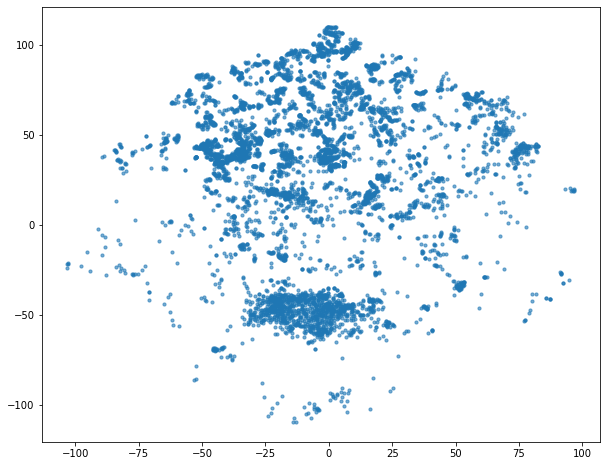

In [ ]:
roi_center_indices_dict = {roi: roi_names.index(roi) for roi in roi_names}
plot_all_rois_tsne(voxel_embeddings_tsne, 
                   inferred_topk_roi_indices_auto, 
                   ROI_names, 
                   title="All ROIs", )

In [39]:
from openTSNE import TSNE

def plot_rois_center_tsne(roi_config:RoiInferConfig, 
                          ROIs_to_plot=None, 
                          title='Rois plot',
                          voxel_embeddings_tsne=None,
                          roi_center_embeddings_tsne=None,
                          plot_roiless=True):
    """It's in a new function because together with the centers we have to do the tsne again 
    """
    
    if ROIs_to_plot is None:
        ROIs_to_plot = roi_config.ROI_names
    else: 
        ROIs_to_plot = [roi for roi in ROIs_to_plot if roi in roi_config.ROI_names]
    
    if voxel_embeddings_tsne is None or roi_center_embeddings_tsne is None:
        
        # Stack center embeddings
        roi_names = list(roi_config.ROI_names)

        roi_center_embeddings = np.vstack([roi_config.roi_centers[roi].detach().cpu().numpy() for roi in roi_names])

        all_embeddings = np.vstack([roi_config.voxel_embeddings.detach().cpu().numpy(), roi_center_embeddings])

        # tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric="correlation")
        # voxel_embeddings_tsne = tsne.fit_transform(voxel_embeddings.detach().squeeze().cpu().numpy())

        # tsne = TSNE(n_components=2, perplexity=30, metric="cosine", random_state=42, n_jobs=-1)
        # voxel_embeddings_tsne = tsne.fit(voxel_embeddings.detach().squeeze().cpu().numpy())

        tsne = TSNE(n_components=2, perplexity=30, metric="cosine", random_state=42, n_jobs=-1)
        all_tsne = tsne.fit(all_embeddings)

        voxel_embeddings_tsne = all_tsne[:len(roi_config.voxel_embeddings)]
        roi_center_embeddings_tsne = all_tsne[len(roi_config.voxel_embeddings):]


    cmap = cm.get_cmap('tab20', len(ROIs_to_plot))
    color_cycle = cycle([cmap(i) for i in range(cmap.N)])

    plt.figure(figsize=(10, 8))

    
    # Plot voxels not assigned to any ROI
    if plot_roiless and roi_config.ROIless_indices is not None and len(roi_config.ROIless_indices) > 0:
        plt.scatter(voxel_embeddings_tsne[roi_config.ROIless_indices, 0],
                    voxel_embeddings_tsne[roi_config.ROIless_indices, 1],
                    label=f'No-ROI Voxels ({len(roi_config.ROIless_indices)})',
                    alpha=0.6,
                    s=10,
                    color='black')
        
    for roi_name in ROIs_to_plot:
        voxel_indices = roi_config.inferred_ROI_indices_dict.get(roi_name)
        if voxel_indices is not None and len(voxel_indices) > 0:
            color = next(color_cycle)

            # Plot voxels of the ROI
            plt.scatter(voxel_embeddings_tsne[voxel_indices, 0],
                        voxel_embeddings_tsne[voxel_indices, 1],
                        label=f'{roi_name} ({len(voxel_indices)})',
                        alpha=0.6,
                        s=10,
                        color=color)
    
    for roi_name in ROIs_to_plot:
        color = next(color_cycle)
        # Plot the center 
        i = ROI_names.index(roi_name)
        plt.scatter(roi_center_embeddings_tsne[i, 0],
                    roi_center_embeddings_tsne[i, 1],
                    color=color,
                    edgecolor='black',
                    marker='X',
                    s=80,
                    linewidths=1.5,
                    label=f'{roi_name} center')


    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return voxel_embeddings_tsne, roi_center_embeddings_tsne



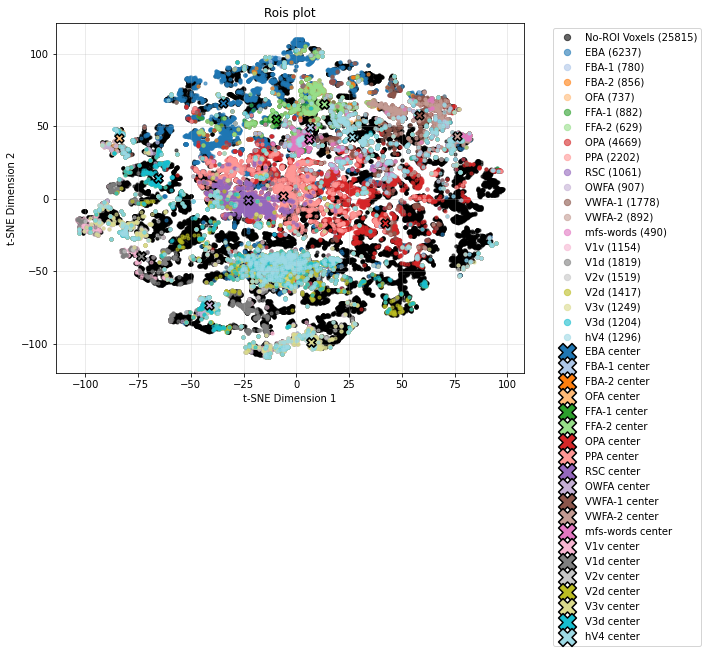

In [48]:
voxel_embeddings_tsne_topk, roi_center_embeddings_tsne_topk = plot_rois_center_tsne(topk_config)

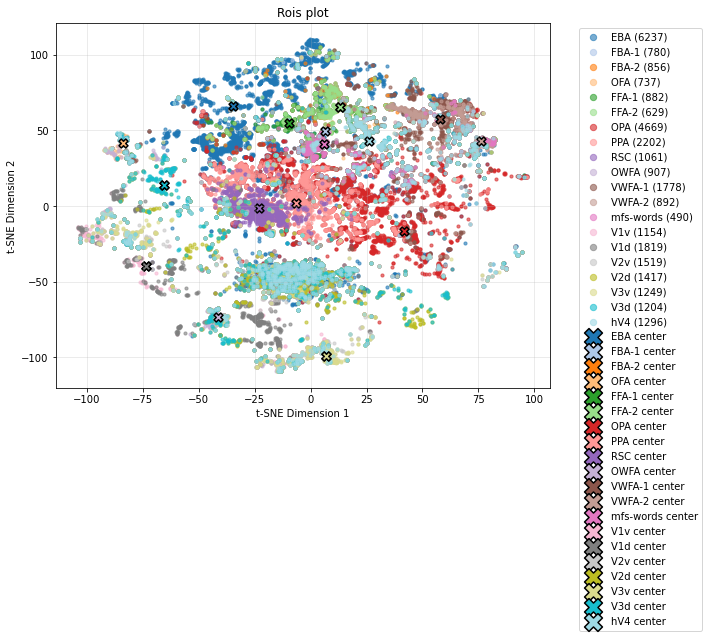

In [49]:
_ = plot_rois_center_tsne(topk_config, 
                      voxel_embeddings_tsne=voxel_embeddings_tsne_topk,
                      roi_center_embeddings_tsne=roi_center_embeddings_tsne_topk,
                      plot_roiless=False,
                    #   ROIs_to_plot=['mfs-words'],
                      )

In [50]:
meanshif_config = ROI_actions.RoiInferConfig(voxel_embeddings=voxel_embeddings, predefined_ROI_indices_dict=predefined_ROI_indices,
    center_method='meanshift', metric='euclidean', discrimination_method='nearest_voxels')
inferred_topk_roi_indices_auto = meanshif_config.infer_roi_dict()
meanshif_config.infer_roiless_indices(sub_indices)

In [ ]:
voxel_embeddings_tsne_ms, roi_center_embeddings_tsne_ms = plot_rois_center_tsne(meanshif_config)

In [ ]:
_ = plot_rois_center_tsne(meanshif_config, 
                      voxel_embeddings_tsne=voxel_embeddings_tsne_ms,
                      roi_center_embeddings_tsne=roi_center_embeddings_tsne_ms,
                      plot_roiless=False,
                    #   ROIs_to_plot=['mfs-words'],
                      )